## Low mass diphoton analysis
### Parametric neural network for signal and background classification (step 2):
* **use the model** trained in `trainingParametricNN_nearestPoint.ipynb`
* **plot ROC curves** considering the inclusive sideband data and mass windows of 10 GeV
* **save NNScore in the trees used for the training** 

**SETUP**: Notebook running in [SWAN](https://swan.web.cern.ch/swan) or locally in an anaconda environent. In the second case, you might need to install the needed packages to run the notebook, e.g.:
```
conda install -c conda-forge matplotlib
conda install h5py
conda install -c conda-forge pandas
conda install -c conda-forge uproot
conda install uproot-methods
pip install tensorflow
conda install scikit-learn
```

A dedicated package that includes a set of helpers for matplotlib to more easily produce plots with the classic CMS style is installed ([mphep](https://github.com/scikit-hep/mplhep)):
```
pip install mplhep
```

In [1]:
import numpy as np
import math, os, h5py
import pandas as pd
import ROOT
import uproot

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
import sklearn

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import mplhep as hep

Welcome to JupyROOT 6.28/00


In [2]:
########################################################################
# Inputs: input files and input trees, training variables, mass points #
########################################################################

approach = "nearest"
#approach = "random"

model_file = "models/model_WeightedCrossEntropyLoss_nearestPoint_100_epochs80.h5"

mass_points = [10, 20, 30, 40, 50, 60, 70]

# List of signal files
file_names_sig = [
    'NTUPLES_Oct2023/ggh/ggH_M10_merged.root',    
    'NTUPLES_Oct2023/ggh/ggH_M20_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M30_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M40_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M50_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M60_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M70_merged.root'    
]

# List of signal tree names
tree_names_sig = [
    'ggh_10_13TeV_UntaggedTag_0',
    'ggh_20_13TeV_UntaggedTag_0',
    'ggh_30_13TeV_UntaggedTag_0',
    'ggh_40_13TeV_UntaggedTag_0',
    'ggh_50_13TeV_UntaggedTag_0',
    'ggh_60_13TeV_UntaggedTag_0',
    'ggh_70_13TeV_UntaggedTag_0'
]

# List of background files
file_names_bkg = [
    'NTUPLES_Oct2023/output_ParaDDFull_wsig_10step.root'
]

# List of background tree names
tree_names_bkg = [
    'Data_13TeV_UntaggedTag_0'
]

# Variables used for training the model
vars_list = [
    'dipho_lead_ptoM', 'dipho_sublead_ptoM',
    'dipho_leadIDMVA', 'dipho_subleadIDMVA',
    'leadEta', 'subleadEta',
    'sigmaMrvoM', 'sigmaMwvoM',
    'cosphi', 'vtxprob',
    'CMS_hgg_mass'
]

# Standardizing variables ranges: reference values used in the training
# ---------------------------------------------------------------------
# Nearest
mean_REF = np.array([1.02221586e+00, 5.92401851e-01, 3.51856716e-01, 1.73320566e-01, 1.37241799e-03, 1.43889548e-03, 1.98240597e-02, 2.66782502e-02, -2.30134385e-01, 7.54484348e-01, 5.10071833e+01])
std_REF = np.array([0.7890904, 0.40491352, 0.58262894, 0.59625774, 1.00148242, 0.9676065, 0.02543319, 0.02461514, 0.77499453, 0.26648426, 16.91191081])

# Random
#mean_REF =  np.array([9.92453636e-01, 5.76560285e-01, 3.64651421e-01, 1.86627699e-01, 1.89154785e-03, 1.51795157e-03, 1.95562936e-02, 2.63900476e-02, -2.68335983e-01, 7.53037223e-01, 4.09308475e+01])
#std_REF =  np.array([0.79372193, 0.41348133, 0.57886452, 0.59570215, 1.00704125, 0.97323678, 0.02527091, 0.02446731, 0.7649603, 0.26688041, 20.21055606])
    
# Random wsig
#mean_REF =  np.array([1.02221586e+00,5.92401851e-01,3.51856716e-01,1.73320566e-01, 1.37241799e-03, 1.43889548e-03, 1.98240597e-02, 2.66782502e-02, -2.30134385e-01,7.54484348e-01,4.09169098e+01])
#std_REF =  np.array([ 0.7890904, 0.40491352, 0.58262894, 0.59625774, 1.00148242, 0.9676065, 0.02543319, 0.02461514, 0.77499453, 0.26648426,20.19474733])

In [3]:
######################################################
# Parametric classifier and loss function definition #
######################################################
class ParametricClassifier(Model):
    def __init__(self, input_shape, architecture=[1, 4, 1], activation='relu', name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        kernel_constraint = None
        self.hidden_layers = [Dense(architecture[i+1], input_shape=(architecture[i],), activation=activation) for i in range(len(architecture)-2)]
        self.output_layer  = Dense(architecture[-1], input_shape=(architecture[-2],), activation='linear')
        self.build(input_shape)
        
    def call(self, x):
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
        x = self.output_layer(x)
        return x

def QuadraticLoss(true, pred):
    y = true[:, 1] #taken from the true_label definition 
    w = true[:, 0] #taken from the true_label definition 
    f = pred[:, 0]
    c = 1./(1+tf.exp(f))
    return 1000*tf.reduce_mean(y*w*c**2 + (1-y)*w*(1-c)**2)
 
def WeightedCrossEntropyLoss(true, pred):
    y   = true[:, 1] #taken from the true_label definition 
    w   = true[:, 0] #taken from the true_label definition
    f   = pred[:, 0]
    return tf.reduce_sum((1-y)*w*tf.math.log(1+tf.exp(f)) + y*w*tf.math.log(1+tf.exp(-1*f))) #activation='linear'

#####################
# Model declaration #
#####################
architecture = [11, 100, 100, 100, 1] # f(x, m) = NN(x, {w}, {b}) || f(x, m) = m * NN(x, {w}, {b})
model = ParametricClassifier(input_shape=(None, 11), architecture=architecture, activation='relu')
optimizer = tf.keras.optimizers.legacy.Adam()
print(model.summary())

model.compile(loss=WeightedCrossEntropyLoss, # QuadraticLoss
              optimizer=optimizer, 
              #metrics=['binary_accuracy']
             )

model.load_weights(model_file)

# Open the HDF5 file in read-only mode to check the content of the model
# ----------------------------------------------------------------------
with h5py.File(model_file, 'r') as file:
    # Print the keys at the root level of the HDF5 file
    print("Root keys:", list(file.keys()))
    
    print("Contents of 'dense':", list(file['dense'])) # weights and vias for each layer
    print("Contents of 'dense_1':", list(file['dense_1']))
    print("Contents of 'dense_2':", list(file['dense_2']))
    print("Contents of 'dense_3':", list(file['dense_3']))
    
    # Access a specific group or dataset within the HDF5 file
    if 'top_level_model_weights' in file:
        print("Contents of 'top_level_model_weights':", list(file['top_level_model_weights']))
    else:
        print("Group or dataset 'top_level_model_weights' not found.")
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense']['dense']
    print("Weights of dense layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_1']['dense_1']
    print("Weights of dense_1 layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_2']['dense_2']
    print("Weights of dense_2 layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_3']['dense_3']
    print("Weights of dense_3 layer:", layer_weights)

Model: "parametric_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1200      
                                                                 
 dense_1 (Dense)             multiple                  10100     
                                                                 
 dense_2 (Dense)             multiple                  10100     
                                                                 
 dense_3 (Dense)             multiple                  101       
                                                                 
Total params: 21501 (83.99 KB)
Trainable params: 21501 (83.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Root keys: ['dense', 'dense_1', 'dense_2', 'dense_3', 'top_level_model_weights']
Contents of 'dense': ['dense']
Contents of 'dense_1': [

In [4]:
# Function to read data from ROOT files and trees
def read_data(file_names, tree_names, vars_list):
    arrays = []
    for file_name, tree_name in zip(file_names, tree_names):
        file = ROOT.TFile.Open(file_name)
        tree = file.Get("tagsDumper/trees/" + tree_name)
        rdf = ROOT.RDataFrame(tree)
        npdf = rdf.AsNumpy(vars_list)
        arrays.append(npdf)
    return arrays

# Function to organize data into numpy arrays
def organize_data(data_arrays, vars_list):
    max_length = max(len(s[var]) for s in data_arrays for var in vars_list)
    data = []
    for var in vars_list:
        var_data = [s[var] for s in data_arrays]
        padded_var_data = [np.pad(d, (0, max_length - len(d))) for d in var_data]
        data.append(np.column_stack(padded_var_data))
    return data

# Function to standardize data
def standardize_data(data, mean, std):
    return (data - mean) / std

# Function to process signal data for all mass points
def process_signal_data(file_names_sig, tree_names_sig, vars_list, mean_REF, std_REF):
    sig_datasets = []
    for file_name, tree_name in zip(file_names_sig, tree_names_sig):
        # Read signal data
        sig_arrays = read_data([file_name], [tree_name], vars_list)
        sig_data = organize_data(sig_arrays, vars_list)
        
        # Standardize signal data
        sig_data = standardize_data(sig_data, mean_REF, std_REF)
        
        sig_datasets.append(sig_data)
    
    return sig_datasets

# Function to read, organize, and standardize background data
def process_background_data(file_names_bkg, tree_names_bkg, vars_list, mean_REF, std_REF):
    # Read background data
    bkg_arrays = read_data(file_names_bkg, tree_names_bkg, vars_list)
    bkg_data = organize_data(bkg_arrays, vars_list)
    
    # Standardize background data
    bkg_data = standardize_data(bkg_data, mean_REF, std_REF)
    
    return bkg_data


# Process signal data for all mass points
sig_datasets = process_signal_data(file_names_sig, tree_names_sig, vars_list, mean_REF, std_REF)

# Process background data
bkg_data = process_background_data(file_names_bkg, tree_names_bkg, vars_list, mean_REF, std_REF)

In [5]:
#########################
# Building the datasets #
#########################

# ---------- #
# BACKGROUND #   
# ---------- #
array_bkg = []

# Loop to get the values for each column for the bkg sample
# ---------------------------------------------------------
for f, tree_name_bkg in enumerate(tree_names_bkg):
    file_name_bkg = file_names_bkg[f]
    file = ROOT.TFile.Open(file_name_bkg)
    tree = file.Get("tagsDumper/trees/" + tree_name_bkg)
    rdf = ROOT.RDataFrame(tree)
    npdf = rdf.AsNumpy(vars_list)
    array_bkg.append(npdf)

bkg_col = [np.hstack([b[var] for b in array_bkg]) for var in vars_list]
bkg = np.column_stack(bkg_col)

# ---------- #
#   SIGNAL   #
# ---------- #
array_sig10 = []
array_sig20 = []
array_sig30 = []
array_sig40 = []
array_sig50 = []
array_sig60 = []
array_sig70 = []

# Loop to get the values for each column for signal samples
# ---------------------------------------------------------
for f, tree_name_sig in enumerate(tree_names_sig):
    file_name_sig = file_names_sig[f]
    file = ROOT.TFile.Open(file_name_sig)
    tree = file.Get("tagsDumper/trees/" + tree_name_sig)
    rdf = ROOT.RDataFrame(tree)
    #npdf = rdf.AsNumpy(vars_list)
    
    if (f==0):
        npdf10 = rdf.AsNumpy(vars_list)
        array_sig10.append(npdf10)
    elif (f==1):
        npdf20 = rdf.AsNumpy(vars_list)
        array_sig20.append(npdf20)
    elif (f==2):
        npdf30 = rdf.AsNumpy(vars_list)
        array_sig30.append(npdf30)
    elif (f==3):
        npdf40 = rdf.AsNumpy(vars_list)
        array_sig40.append(npdf40)
    elif (f==4):
        npdf50 = rdf.AsNumpy(vars_list)
        array_sig50.append(npdf50)
    elif (f==5):
        npdf60 = rdf.AsNumpy(vars_list)
        array_sig60.append(npdf60)
    elif (f==6):
        npdf70 = rdf.AsNumpy(vars_list)
        array_sig70.append(npdf70)

sig10_col = [np.hstack([s[var] for s in array_sig10]) for var in vars_list]
sig10 = np.column_stack(sig10_col)

sig20_col = [np.hstack([s[var] for s in array_sig20]) for var in vars_list]
sig20 = np.column_stack(sig20_col)

sig30_col = [np.hstack([s[var] for s in array_sig30]) for var in vars_list]
sig30 = np.column_stack(sig30_col)

sig40_col = [np.hstack([s[var] for s in array_sig40]) for var in vars_list]
sig40 = np.column_stack(sig40_col)

sig50_col = [np.hstack([s[var] for s in array_sig50]) for var in vars_list]
sig50 = np.column_stack(sig50_col)

sig60_col = [np.hstack([s[var] for s in array_sig60]) for var in vars_list]
sig60 = np.column_stack(sig60_col)

sig70_col = [np.hstack([s[var] for s in array_sig70]) for var in vars_list]
sig70 = np.column_stack(sig70_col)

In [6]:
####################################
# --STANDARDIZING VARIABLES RANGES #
####################################
# Make the dataset invariant for scale effects.
# Rule to transform data to be in a proper shape to apply the model

def standardize_dataset(data, mean, std):
    return (data - mean) / std

sig10 = standardize_dataset(sig10, mean_REF, std_REF)
sig20 = standardize_dataset(sig20, mean_REF, std_REF)
sig30 = standardize_dataset(sig30, mean_REF, std_REF)
sig40 = standardize_dataset(sig40, mean_REF, std_REF)
sig50 = standardize_dataset(sig50, mean_REF, std_REF)
sig60 = standardize_dataset(sig60, mean_REF, std_REF)
sig70 = standardize_dataset(sig70, mean_REF, std_REF)
bkg = standardize_dataset(bkg, mean_REF, std_REF)

In [7]:
# Create a dictionary with NN scores for the MC signal events 
preds_dict = {mass: tf.sigmoid(model.predict(sig[:, :])).numpy()[:, 0] for mass, sig in zip(mass_points, [sig10, sig20, sig30, sig40, sig50, sig60, sig70])}

# Make predictions for background 
predsBkg = tf.sigmoid(model.predict(bkg[:, :])).numpy()[:, 0]

35346/35346 [==============================] - 16s 447us/step


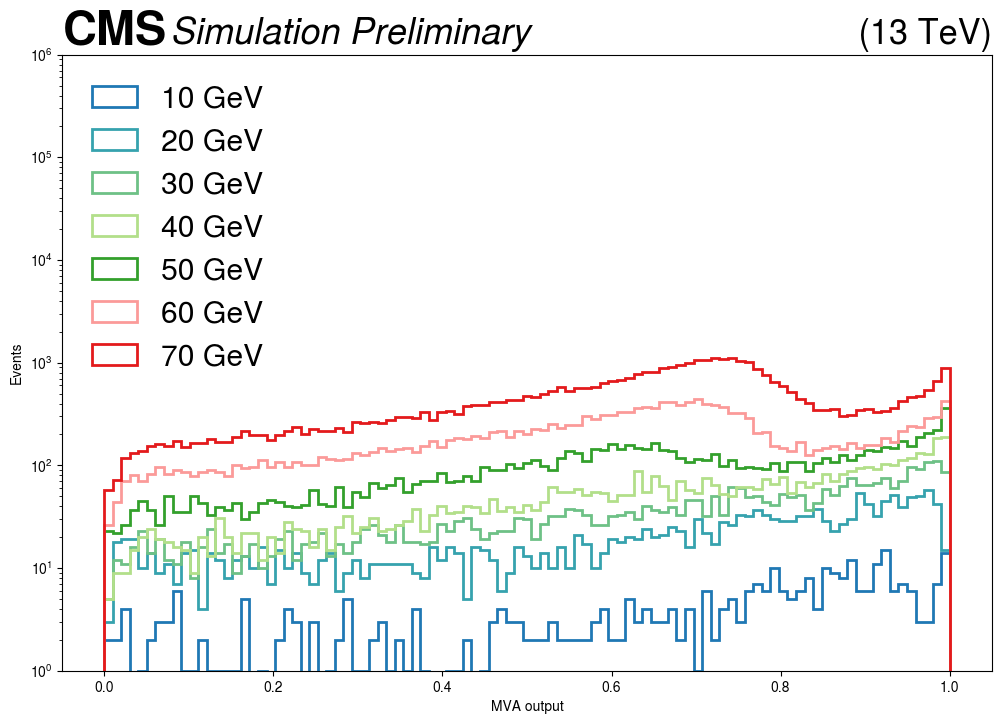

In [8]:
#colors = ['#FF6666', '#FFB266', '#FFCC66', '#C2FF66', '#66FF66', '#66FFB2', '#66FFCC']
colors = ['#1f78b4', '#36a2ae', '#6ec186', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each prediction array and plot it with a different color
for mass, color in zip(mass_points, colors):
    preds = preds_dict[mass]
    ax.hist(preds, bins=np.linspace(0., 1., 100), color=color, label=f'{mass} GeV', histtype='step', linewidth=2)

ax.set_yscale('log')
ax.set_ylim(1, 1000000)  # Set y-axis limits
ax.set_xlabel('MVA output')
ax.set_ylabel('Events')
ax.legend(loc='upper right')

plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)

plt.legend()
#plt.show()
plt.savefig("Plots/nearest/MVAOutputs/massSpectrum/allMVAOutputs.png")
plt.savefig("Plots/nearest/MVAOutputs/massSpectrum/allMVAOutputs.pdf")


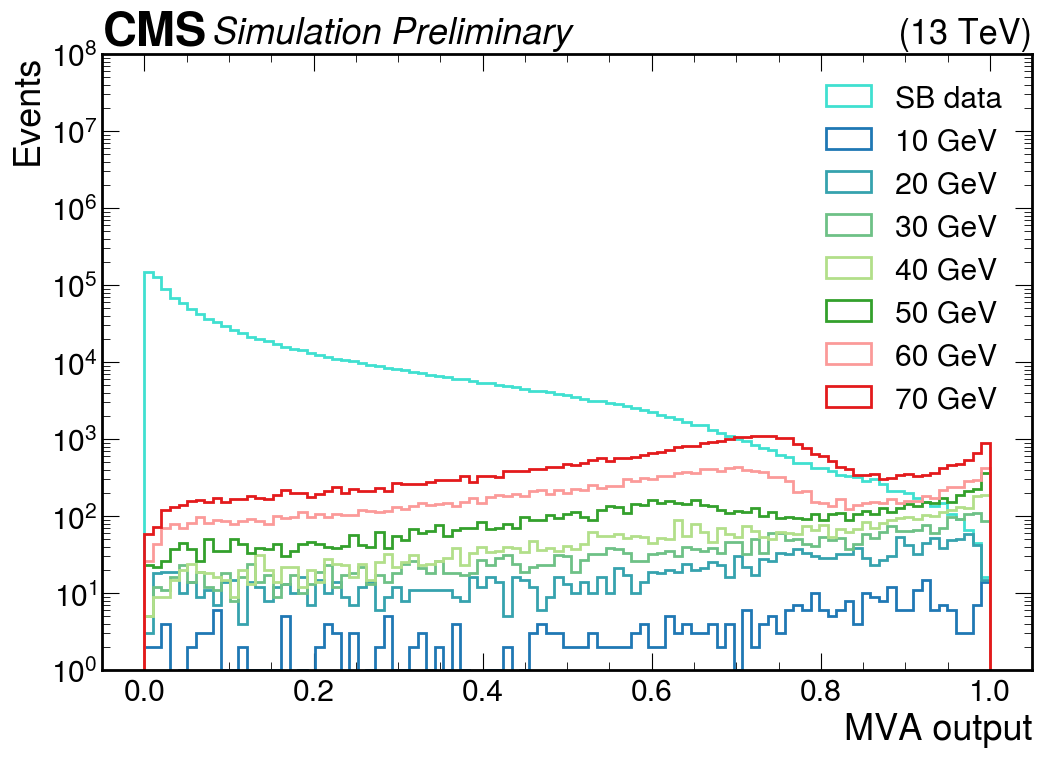

In [9]:
#colors = ['#FF6666', '#FFB266', '#FFCC66', '#C2FF66', '#66FF66', '#66FFB2', '#66FFCC']
colors = ['#1f78b4', '#36a2ae', '#6ec186', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(predsBkg, bins=np.linspace(0., 1., 100), color="turquoise", label='SB data', histtype='step', linewidth=2)

# Loop through each prediction array and plot it with a different color
for mass, color in zip(mass_points, colors):
    preds = preds_dict[mass]
    ax.hist(preds, bins=np.linspace(0., 1., 100), color=color, label=f'{mass} GeV', histtype='step', linewidth=2)

ax.set_yscale('log')
ax.set_ylim(1, 100000000)  # Set y-axis limits
ax.set_xlabel('MVA output')
ax.set_ylabel('Events')
ax.legend(loc='upper right')

plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)

plt.legend()
plt.savefig("Plots/nearest/MVAOutputs/massSpectrum/allMVAOutputs_plusBkg.png")
plt.savefig("Plots/nearest/MVAOutputs/massSpectrum/allMVAOutputs_plusBkg.pdf")

# Testing the current predictions signal versus data 

36719/36719 [==============================] - 17s 463us/step
Mass 10 GeV - AUC: 0.92
Mass 20 GeV - AUC: 0.92
Mass 30 GeV - AUC: 0.94
Mass 40 GeV - AUC: 0.95
Mass 50 GeV - AUC: 0.94
Mass 60 GeV - AUC: 0.93
Mass 70 GeV - AUC: 0.94


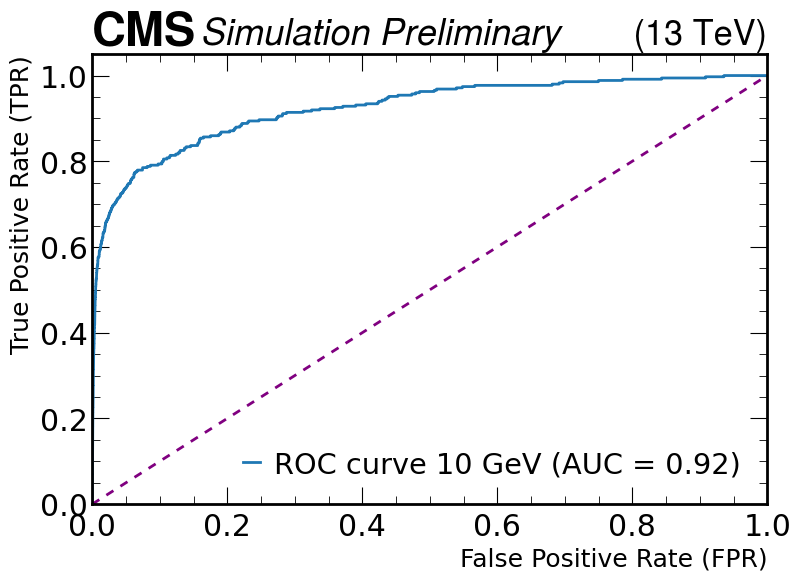

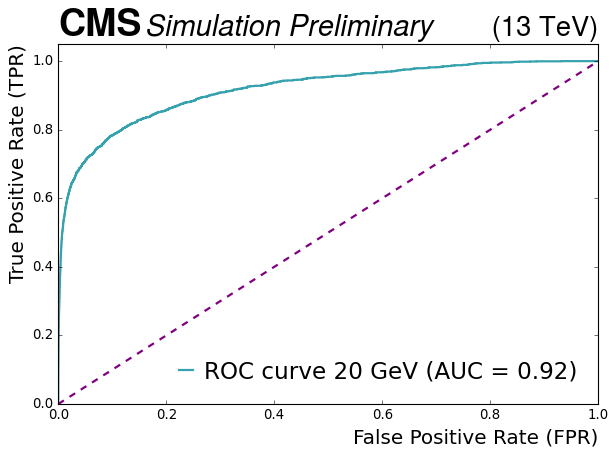

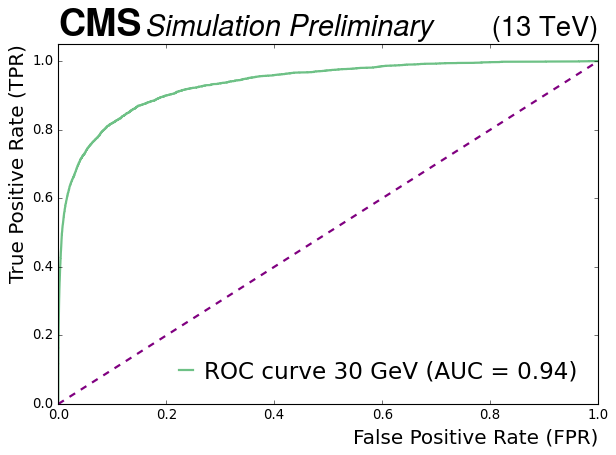

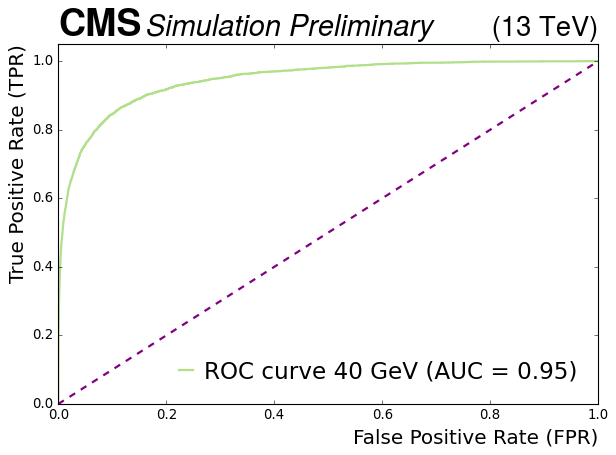

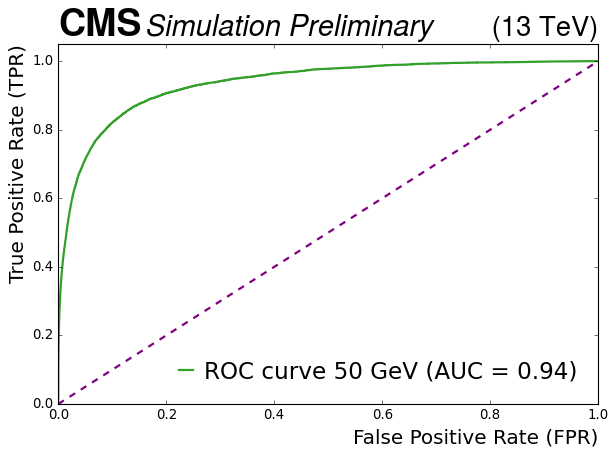

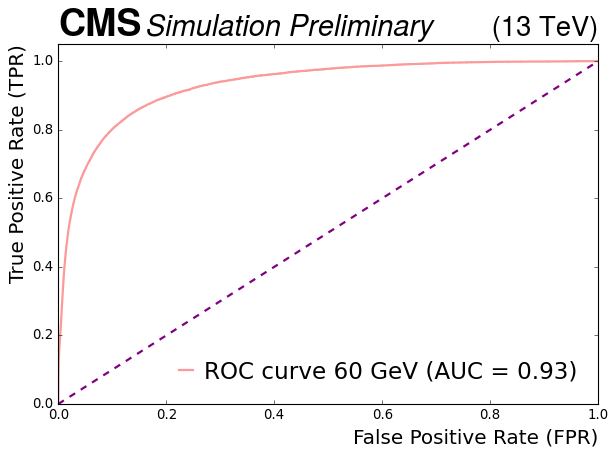

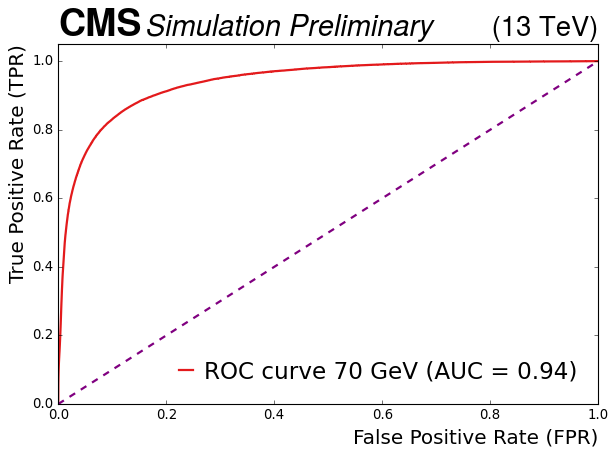

In [10]:
from sklearn.metrics import roc_curve, auc

outdir = "Plots/"+approach+"/roc"

sig_dict = {}
y_bkg = np.zeros((bkg.shape[0], 1))

for mass_point in mass_points:
    sig_dict[mass_point] = locals()[f'sig{mass_point}']

# Create a dictionary to store ROC curves and AUC values
roc_dict = {}

# Loop over each mass point
for mass, color in zip(mass_points, colors):

    # Create target labels for the current mass point
    y_sig_mass = np.ones((sig_dict[mass].shape[0], 1))

    # Concatenate data for the current mass point
    testing_data_mass = np.concatenate((bkg, sig_dict[mass]), axis=0)
    testing_true_label_mass = np.concatenate((y_bkg, y_sig_mass), axis=0)
    
    # Get predictions for the current mass point
    newPreds = tf.sigmoid(model.predict(testing_data_mass[:, :])).numpy()[:, 0]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(testing_true_label_mass[:, 0]==1, newPreds)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Store ROC curve and AUC in the dictionary
    roc_dict[mass] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Plot ROC curve for the current mass point
    fig = plt.figure(figsize=(9, 6))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes([0.2, 0.15, 0.75, 0.75])
    plt.style.use(hep.style.ROOT)
    hep.cms.label("Preliminary", data=False)
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    plt.plot(fpr, tpr, lw=2, color=color, label=f'ROC curve {mass} GeV (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=18)
    plt.ylabel('True Positive Rate (TPR)', fontsize=18)
    legend = plt.legend(loc="lower right", handlelength=0, fontsize='xx-large')
    legend.set_frame_on(False)
    #plt.show()
    plt.savefig(outdir + f'/roc_curve_WeightedCrossEntropyLoss_{mass}GeV.png')

# Access ROC curves and AUC values from the dictionary
for mass, roc_data in roc_dict.items():
    print(f'Mass {mass} GeV - AUC: {roc_data["roc_auc"]:.2f}')

In [11]:
#########################################
#    BACKGROUND: create mass windows    #
######################################### 
array_bkg10 = []
array_bkg20 = []
array_bkg30 = []
array_bkg40 = []
array_bkg50 = []
array_bkg60 = []
array_bkg70 = []

file_name_bkg = 'output_ParaDDFullWgts_10step.root'
file = ROOT.TFile.Open(file_name_bkg)
tree = file.Get("tagsDumper/trees/Data_13TeV_UntaggedTag_0")
    
rdf10 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 5. && CMS_hgg_mass < 15."))
npdf10 = rdf10.AsNumpy(vars_list)
array_bkg10.append(npdf10)
    
rdf20 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 15. && CMS_hgg_mass < 25."))
npdf20 = rdf20.AsNumpy(vars_list)
array_bkg20.append(npdf20)

rdf30 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 25. && CMS_hgg_mass < 35."))
npdf30 = rdf30.AsNumpy(vars_list)
array_bkg30.append(npdf30)

rdf40 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 35. && CMS_hgg_mass < 45."))
npdf40 = rdf40.AsNumpy(vars_list)
array_bkg40.append(npdf40)

rdf50 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 45. && CMS_hgg_mass < 55."))
npdf50 = rdf50.AsNumpy(vars_list)
array_bkg50.append(npdf50)

rdf60 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 55. && CMS_hgg_mass < 65."))
npdf60 = rdf60.AsNumpy(vars_list)
array_bkg60.append(npdf60)

rdf70 = ROOT.RDataFrame(tree).Filter(("CMS_hgg_mass >= 65. && CMS_hgg_mass < 75."))
npdf70 = rdf70.AsNumpy(vars_list)
array_bkg70.append(npdf70)
    
    
bkg10_col = [np.hstack([b[var] for b in array_bkg10]) for var in vars_list]
bkg10 = np.column_stack(bkg10_col)

bkg20_col = [np.hstack([b[var] for b in array_bkg20]) for var in vars_list]
bkg20 = np.column_stack(bkg20_col)

bkg30_col = [np.hstack([b[var] for b in array_bkg30]) for var in vars_list]
bkg30 = np.column_stack(bkg30_col)

bkg40_col = [np.hstack([b[var] for b in array_bkg40]) for var in vars_list]
bkg40 = np.column_stack(bkg40_col)

bkg50_col = [np.hstack([b[var] for b in array_bkg50]) for var in vars_list]
bkg50 = np.column_stack(bkg50_col)

bkg60_col = [np.hstack([b[var] for b in array_bkg60]) for var in vars_list]
bkg60 = np.column_stack(bkg60_col)

bkg70_col = [np.hstack([b[var] for b in array_bkg70]) for var in vars_list]
bkg70 = np.column_stack(bkg70_col)

####################################
# --STANDARDIZING VARIABLES RANGES #
####################################
bkg10 = standardize_dataset(bkg10, mean_REF, std_REF)
bkg20 = standardize_dataset(bkg20, mean_REF, std_REF)
bkg30 = standardize_dataset(bkg30, mean_REF, std_REF)
bkg40 = standardize_dataset(bkg40, mean_REF, std_REF)
bkg50 = standardize_dataset(bkg50, mean_REF, std_REF)
bkg60 = standardize_dataset(bkg60, mean_REF, std_REF)
bkg70 = standardize_dataset(bkg70, mean_REF, std_REF)

In [12]:
# Create a dictionary with NN scores for the bkg events (from SB data) separated in mass windows
predsBkg_dict = {mass: tf.sigmoid(model.predict(bkg[:, :])).numpy()[:, 0] for mass, bkg in zip(mass_points, [bkg10, bkg20, bkg30, bkg40, bkg50, bkg60, bkg70])}

8345/8345 [==============================] - 3s 400us/step


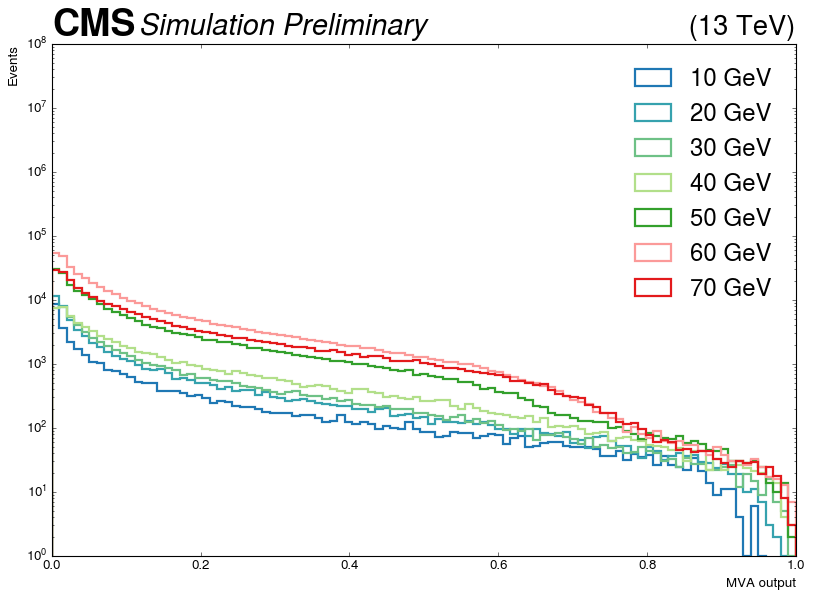

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')

# Loop through each prediction array and plot it with a different color
for mass, color in zip(mass_points, colors):
    preds = predsBkg_dict[mass]
    ax.hist(preds, bins=np.linspace(0., 1., 100), color=color, label=f'{mass} GeV', histtype='step', linewidth=2)

ax.set_yscale('log')
ax.set_ylim(1, 100000000)  # Set y-axis limits
ax.set_xlabel('MVA output')
ax.set_ylabel('Events')
ax.legend(loc='upper right')
#plt.yscale('log')
#plt.ylim(1, 25000)  # Set y-axis limits
#plt.xlabel("MVA output")
#plt.ylabel("Events")

plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)

plt.legend()
#plt.show()
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputsBkg_massWindows.png")
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputsBkg_massWindows.pdf")

9718/9718 [==============================] - 4s 411us/step
Mass 10 GeV - AUC: 0.93
Mass 20 GeV - AUC: 0.93
Mass 30 GeV - AUC: 0.94
Mass 40 GeV - AUC: 0.93
Mass 50 GeV - AUC: 0.94
Mass 60 GeV - AUC: 0.93
Mass 70 GeV - AUC: 0.93


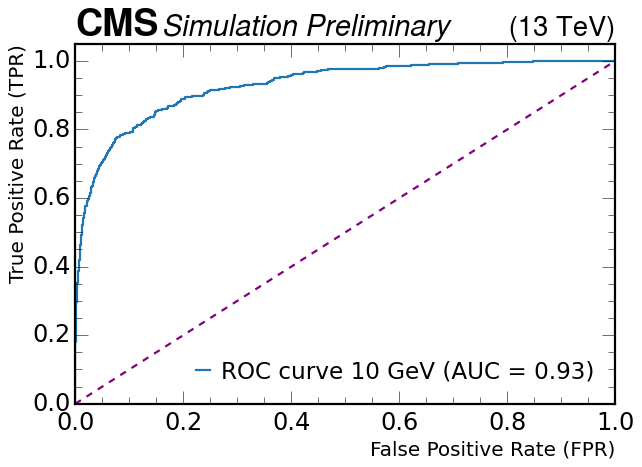

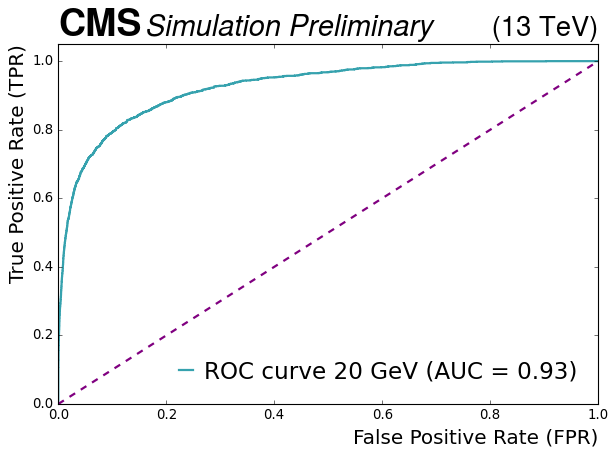

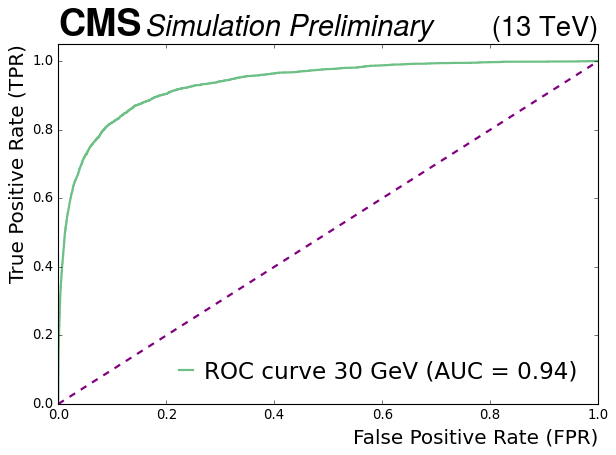

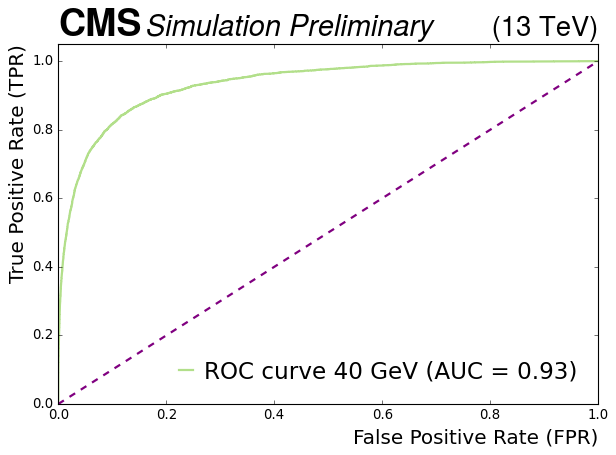

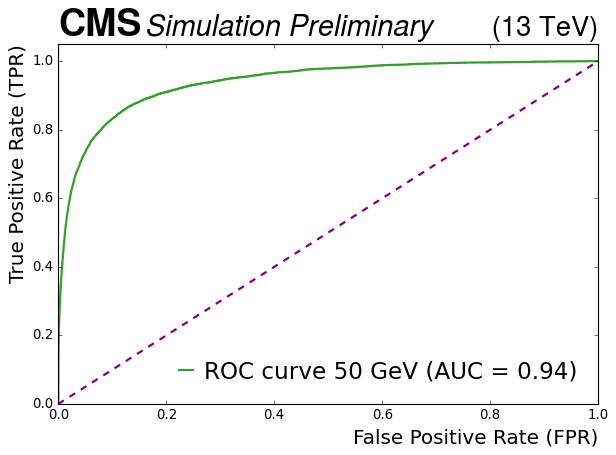

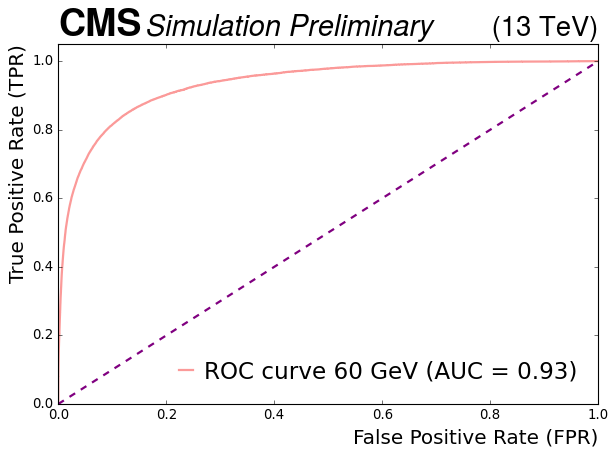

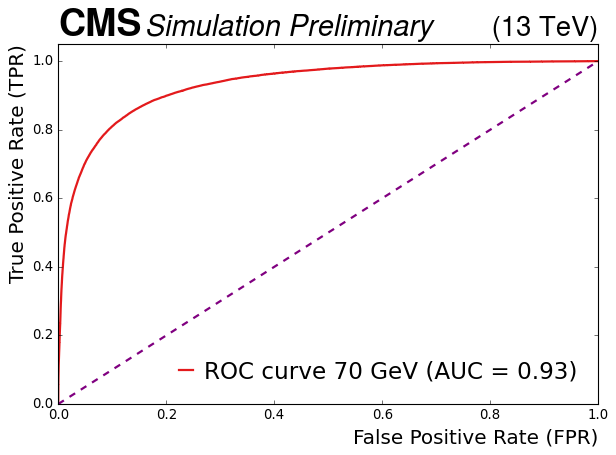

In [14]:
outdir = "Plots/"+approach+"/roc_massWindows"

bkg_dict = {}

for mass_point in mass_points:
    bkg_dict[mass_point] = locals()[f'bkg{mass_point}']

# Create a dictionary to store ROC curves and AUC values
roc_dict_massWindow = {}

# Loop over each mass point
for mass, color in zip(mass_points, colors):
    # Create target labels for the current mass point
    y_sig_mass = np.ones((sig_dict[mass].shape[0], 1))
    y_bkg_mass = np.zeros((bkg_dict[mass].shape[0], 1))

    # Concatenate data for the current mass point
    testing_data_massWindow = np.concatenate((bkg_dict[mass], sig_dict[mass]), axis=0)
    testing_true_label_massWindow = np.concatenate((y_bkg_mass, y_sig_mass), axis=0)
    
    # Get predictions for the current mass point
    newPreds_massWindow = tf.sigmoid(model.predict(testing_data_massWindow[:, :])).numpy()[:, 0]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(testing_true_label_massWindow[:, 0]==1, newPreds_massWindow)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Store ROC curve and AUC in the dictionary
    roc_dict_massWindow[mass] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Plot ROC curve for the current mass point
    fig = plt.figure(figsize=(9, 6))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes([0.2, 0.15, 0.75, 0.75])
    plt.style.use(hep.style.ROOT)
    hep.cms.label("Preliminary", data=False)
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    plt.plot(fpr, tpr, lw=2, color=color, label=f'ROC curve {mass} GeV (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=18)
    plt.ylabel('True Positive Rate (TPR)', fontsize=18)
    legend = plt.legend(loc="lower right", handlelength=0, fontsize='xx-large')
    legend.set_frame_on(False)
    #plt.show()
    plt.savefig(outdir + f'/roc_curve_WeightedCrossEntropyLoss_{mass}GeV_massWindow.png')

# Access ROC curves and AUC values from the dictionary
for mass, roc_data in roc_dict_massWindow.items():
    print(f'Mass {mass} GeV - AUC: {roc_data["roc_auc"]:.2f}')

### Add prediction to ROOT trees

In [16]:
#################################################
# Add prediction to ROOT trees: signal samples  #
#################################################

import ROOT
from array import array

ROOT.gROOT.SetBatch()
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

# Loop over each mass point
for mass_point in mass_points:
    print(f"Processing mass point {mass_point} GeV")

    # Open the input file for the current mass point
    infile_name = f"NTUPLES_Oct2023/ggh/ggH_M{mass_point}_merged.root"
    infile = ROOT.TFile(infile_name, "read")

    # Create a new output file for the current mass point
    outfile_name = "NTUPLES_Oct2023/newFiles/"+approach+"/out_ggH_M"+str(mass_point)+"_merged_v3.root"
    newfile = ROOT.TFile(outfile_name, "recreate")

    # Create the necessary directories
    tagsDumper = newfile.mkdir("tagsDumper")
    tagsDumper.cd()
    trees = tagsDumper.mkdir("trees")

    # Get the old tree from the input file for the corresponding mass point
    oldtree = infile.Get(f"tagsDumper/trees/ggh_{mass_point}_13TeV_UntaggedTag_0")
    nentries = oldtree.GetEntries()
    print("nentries = ", nentries)

    # Create a new tree with the same structure
    NNScore = array('f', [0.])
    newtree = oldtree.CloneTree(0)
    newtree.Branch("NNScore", NNScore, "NNScore/F")

    # Loop over the entries and fill the new tree with random values
    count = 0
    print("---------- Opening the tree")
    for i in oldtree:
        NNScore[0] = preds_dict[mass_point][count]
        newtree.Fill()
        count += 1

    print("---------- Save and close the tree")
    # Save the new tree to the new file
    trees.cd()
    newtree.Write()

    # Close the current input file
    infile.Close()
    # Close the output file for the current mass point
    newfile.Close()

Processing mass point 10 GeV
nentries =  349
---------- Opening the tree
---------- Save and close the tree
Processing mass point 20 GeV
nentries =  1935
---------- Opening the tree
---------- Save and close the tree
Processing mass point 30 GeV
nentries =  3395
---------- Opening the tree
---------- Save and close the tree
Processing mass point 40 GeV
nentries =  4933
---------- Opening the tree
---------- Save and close the tree
Processing mass point 50 GeV
nentries =  9269
---------- Opening the tree
---------- Save and close the tree
Processing mass point 60 GeV
nentries =  19135
---------- Opening the tree
---------- Save and close the tree
Processing mass point 70 GeV
nentries =  43933
---------- Opening the tree
---------- Save and close the tree


In [17]:
##################################################
# Add prediction to ROOT trees: background data  #
##################################################

# Open the input file: SB data events
infile = ROOT.TFile("NTUPLES_Oct2023/output_ParaDDFull_wsig_10step.root", "read")
# Create a new output file
newfile = ROOT.TFile("NTUPLES_Oct2023/newFiles/"+approach+"/out_sbData_bkg_v3.root", "recreate")

# Open the input file: all 2018 data events
#infile = ROOT.TFile("NTUPLES_Oct2023/data/data_EGamma_2018.root", "read")

# Create a new output file
#newfile = ROOT.TFile("NTUPLES_Oct2023/newFiles/"+approach+"/out_all2018Data_bkg_v3.root", "recreate")

# Create the necessary directories
tagsDumper = newfile.mkdir("tagsDumper")
tagsDumper.cd()
trees = tagsDumper.mkdir("trees")

# Get the old tree from the input file
oldtree = infile.Get("tagsDumper/trees/Data_13TeV_UntaggedTag_0")
nentries = oldtree.GetEntries()
print("nentries = ", nentries)

# Create a new tree with the same structure
NNScore = array('f', [0.])
newtree = oldtree.CloneTree(0)
newtree.Branch("NNScore", NNScore, "NNScore/F")
    
# Loop over the entries and fill the new tree with random values
print("---------- Opening the sb data tree")
count = 0
for i in oldtree:
    #if (count == 1000): break
    NNScore[0] = predsBkg[count]
    newtree.Fill()
    count += 1
    
print("---------- Save and close the sb data tree")
# Save the new tree to the new file
trees.cd()
newtree.Write()
newfile.Close()

nentries =  1131055
---------- Opening the sb data tree
---------- Save and close the sb data tree
